## Rekognition Custom Label Introduction
With Amazon Rekognition Custom Labels, you can identify the objects and scenes in images that are specific to your business needs. For example, you can find your logo in social media posts, identify your products on store shelves, classify machine parts in an assembly line, distinguish healthy and infected plants etc.

Amazon Rekognition Custom Labels extends Amazon Rekognition’s existing capabilities, which are already trained on tens of millions of images across many categories. Instead of thousands of images, you can upload a small set of training images (typically a few hundred images or less) that are specific to your use case. You can do this by using the easy-to-use console. If your images are already labeled, Amazon Rekognition Custom Labels can begin training a model in a short time. If not, you can label the images directly within the labeling interface, or you can use Amazon SageMaker Ground Truth to label them for you.


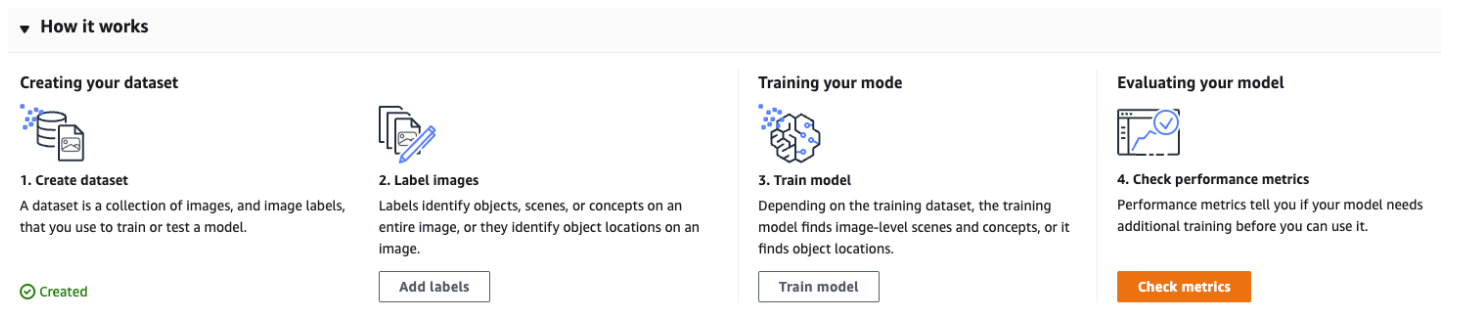

## Copying the dataset to S3 bucket

First, please make sure that the kernel is set to Python3 (Data Science)

- Once you are loggged in to the console, create a S3 bucket with a unique name and create a folder called AWS.

- Download the dataset from the below link

https://static.us-east-1.prod.workshops.aws/public/b1d4e647-48f7-4cbd-9196-ce80f1c308af/static/custom_labels_logo_detection/preprocessing/_index.en.files/aws-logo-images.zip

- Unzip the file and import all the image files to your folder.

## Rekognition Custom Label Project and Dataset Creation

Follow the steps in the below link to create a project in Rekognition Custom Label followed by dataset creation and labelling. 

https://catalog.us-east-1.prod.workshops.aws/workshops/4a2a9a24-071d-4d96-b9be-0cc57b7db434/en-US/custom-labels-logo-detection/preprocessing

## Rekognition Custom Label Model Training

Once labelling is done, next click on "Train model". Model training will take ~1 hours. In the console, if you select your project, you should see a status like TRAINING_IN_PROGRESS. 

## Rekognition Custom Label Model Metric Verification

Once the model is trained, you should be able to see the results similar to the below.

You can click on `View test results` to look at individual test image result

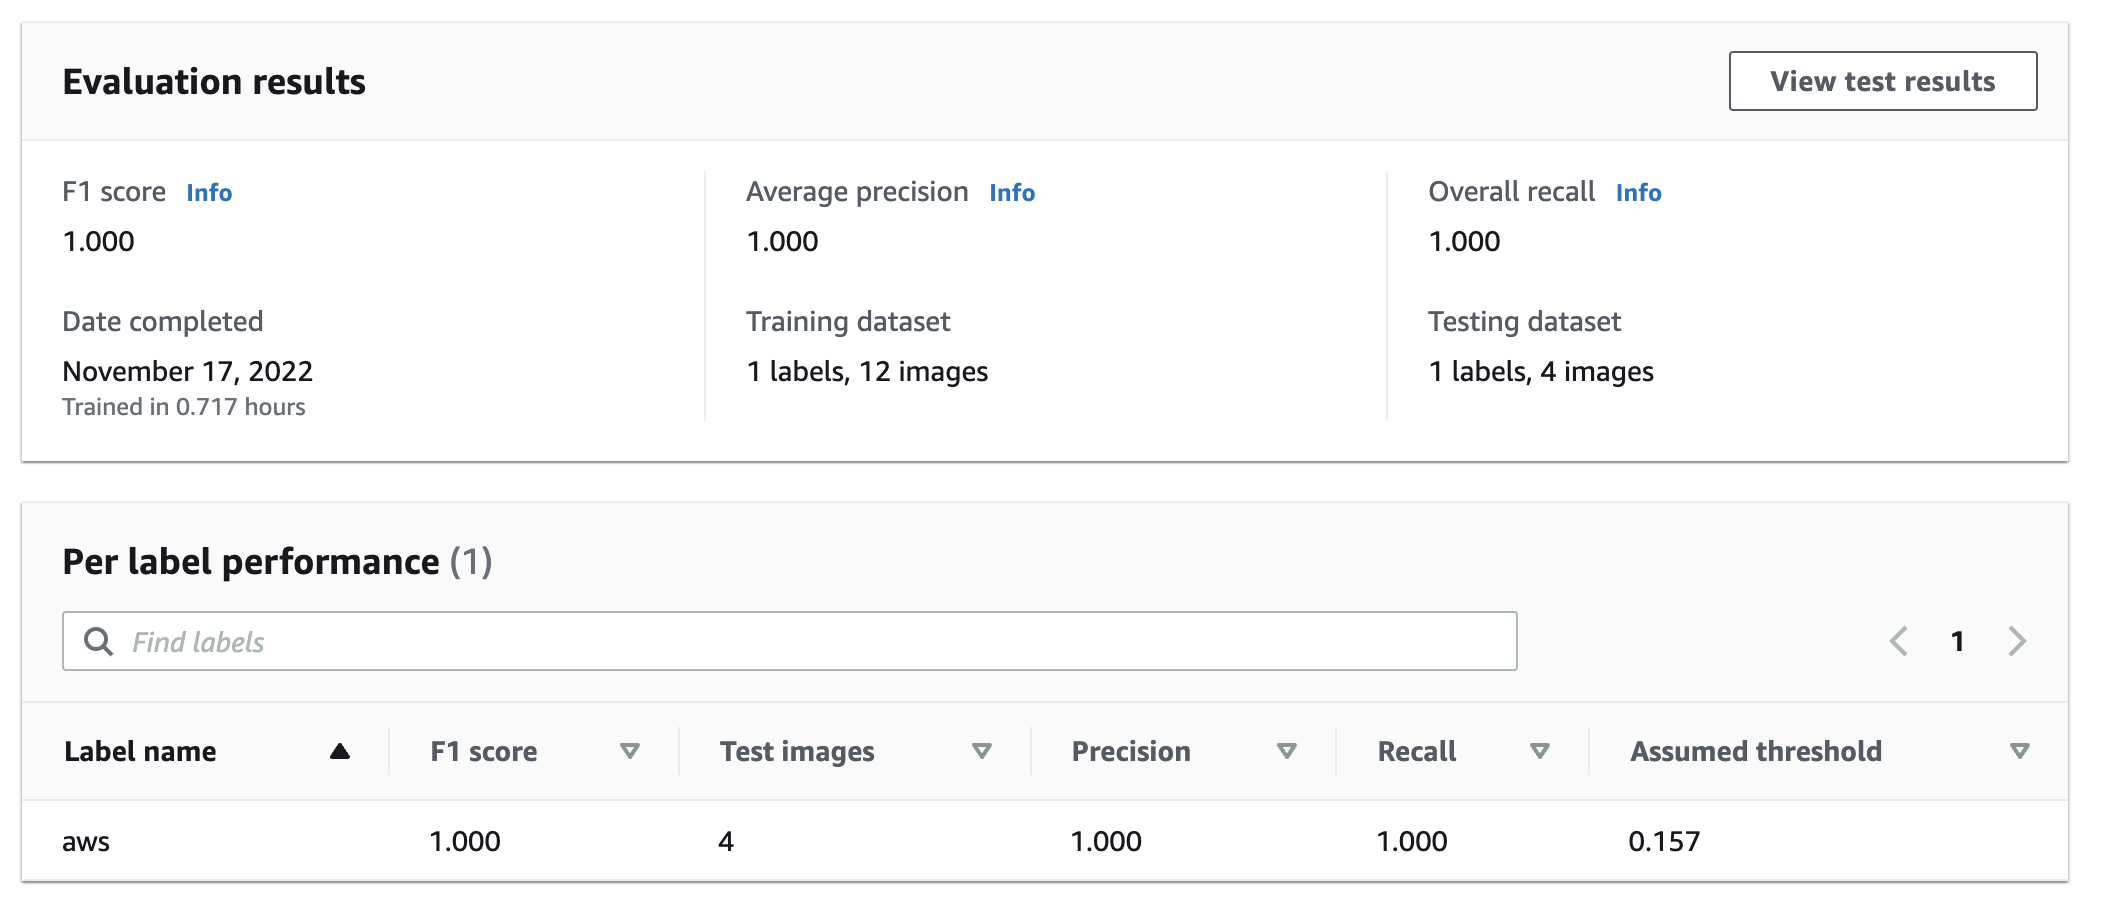

## Testing the model for inference

Now you can open JupyterLab and import the notebook.

In [ ]:
# Import libraries and necessary set-up

import boto3
import io
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import json
import math

client=boto3.client('rekognition')
s3 = boto3.client('s3')
s3_connection = boto3.resource('s3')

my_bucket='rekognitioncustomlabel2022'   #change to your own bucket name

## Start The Model

You can start the model from the console. Under `Use model` click on `start model`

## Testing the model

Let's check if the model can predict the label  correctly for some test images

In [ ]:
img = "test_images/aws-test-1.jpeg"
display(IImage(img))

Let's upload the test images to S3 so that we can invoke the rekognition custom label API to test the images

In [ ]:
s3.upload_file(img, my_bucket, img)

Now, let's call the Rekognition custom label API to analyze the image and get the JSON response

In [ ]:
import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

def display_image(bucket,img,response):
    # Load image from S3 bucket

    s3_object = s3_connection.Object(bucket,img)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)
    
  
    # calculate and display bounding boxes for each detected custom label
    for customLabel in response['CustomLabels']:
 
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

            fnt = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf", 65)
            # use red for level 50 and blue for level 75
            if (customLabel['Name'] == "Level_50"):
                fontColor = "red"
            else:
                fontColor = "blue"
                
            draw.text((left,top-100), customLabel['Name'], fontColor, font=fnt)

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)

    display(image)
    

def show_custom_labels(model,bucket,img, min_confidence):

    # Call DetectCustomLabels
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': img}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)
    
    # display image.
    display_image(bucket,img,response)

    #return the json response
    return (json.dumps(response['CustomLabels'], indent=2))

def main():

    model='arn:aws:rekognition:ap-southeast-1:032225433545:project/logo-detection/version/logo-detection.2022-11-17T09.18.14/1668647894879'
    min_confidence=50

    label_count=show_custom_labels(model,my_bucket,img, min_confidence)
    display_image(my_bucket,img,response)

    print("Custom labels detected: " + str(label_count))


if __name__ == "__main__":
    main()